In [12]:
import torch
import torch.nn as nn
from torch.nn.functional import logsigmoid
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
from src.models import get_model
from src.ema import EMAHelper
from src.dataset import create_dataset
from src.model_utils import get_loss

## Change relevant paths here

In [4]:
# path to ckpt
ckpt_path = "path/to/ckpt"

# if None, use the device of the saved checkpoint. else replace with "cpu", "cuda:0" or list of device ids [0, 1] etc
device = "cuda:0"

# dataset directory containing the cat2dog folders
data_dir = "path/to/data dir"

In [5]:
ckpt = torch.load(ckpt_path)
config = ckpt['config']
device = config['device']
if isinstance(device, list):
    multi_gpu = True
    device_ids = device
    device = 'cuda:' + str(device_ids[0]) # if multi-GPUs, set default device to the first gpu
else:
    multi_gpu = False
    
model = get_model(config)
if multi_gpu:
    model = nn.DataParallel(model, device_ids=device_ids)

if config['ema']:
    ema_helper = EMAHelper(mu=config['ema_rate'])
    ema_helper.load_state_dict(ckpt['ema'])
    model = ema_helper.ema_copy(model)
else:
    model.load_state_dict(ckpt['model'])
model = model.to(device)
print(f"Loading checkpoint step {ckpt['step']}")

Loading checkpoint step 39999


In [9]:
def one_step_flow(x, model, eta, noise_factor, f_divergence):

    x_k = torch.autograd.Variable(x.clone(), requires_grad=True)
    nn_out = model(x_k)
    
    if f_divergence == 'Pearson':
        f_prime = 2*nn_out
    elif f_divergence == 'KL':
        f_prime = nn_out
    elif f_divergence == 'JS':
        f_prime = logsigmoid(nn_out)
    elif f_divergence == 'logD':
        f_prime = -logsigmoid(-nn_out)
    else:
        print("f_divergence is not valid")
    
    grad = torch.autograd.grad(f_prime.sum(), [x_k], retain_graph=True)[0]
    x_k.data -= eta * grad + noise_factor * torch.randn_like(x_k)
    return x_k.detach()

In [15]:
bs = 8
f_divergence = config['f_divergence']
eta = config['eta']
noise_factor = config['noise_factor']
loss_func = config['loss_function']
n_flow_steps = config['n_flow_steps']
config['train_batch_size'] = bs


In [16]:
test_config = config.copy()
test_config['phase'] = 'test'
test_dataloader = create_dataset(test_config)
test_iter = iter(test_dataloader)
test_batch = next(test_iter)[0] # test samples from domain A

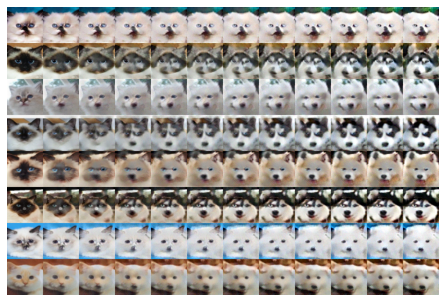

In [18]:
x_arr = []

for j in range(bs):
    interp_x = test_batch[j].to(device).unsqueeze(0)
    for i in range(n_flow_steps+10):
        interp_x = one_step_flow(interp_x, model, eta, noise_factor, f_divergence)
        if i==0 or (i+1) % 10 == 0 or (i+1)==n_flow_steps+10:
            x_arr.append(interp_x)
    
x_arr = torch.cat(x_arr,dim=0)
grid = make_grid(x_arr.clamp(-1., 1.).cpu(), nrow=12, normalize=True, padding=0)
f = plt.figure(figsize = (6,5))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(grid.permute(1, 2, 0))
plt.show()